# This is the submission Notebook of Team Sigmoid Freud 
by Qianjing, Danie, Jacob, Fan, Jan

# <b>1.Load Data and Packages</b>
<b>Firstly, we downloaded the data, imported necessary packages and loaded the data into DataFrames. </b>

In [ ]:
#Demonstration data used in this excercise is already preprocessed and split into
#training, validation, and test sets

#Use wget to download the data stored in csv format.
import itertools

#Define what files to download; download all of the preprocessed data
#Note that the data are already split into Train, Validation, and Test sets.
#The predictor data are denoted with 'X', the target by 'y'
data_download = {}
data_download["window_size"] = [5, 15]
data_download["data_type"] = ["train", "valid", "test"]
data_download["predictor_or_target"] = ["X", "y"]

#Prepare the combinations of the window sizes and the data types
keys, values = zip(*data_download.items())
data_download_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
display('The kind of data to be downloaded:', data_download_combinations)

print("Downloading started...")
for data_download_param in data_download_combinations:
    file_to_download = "https://frankfurt-school-dataset.s3.eu-central-1.amazonaws.com/Sept2021/window_size_{0}_time_encoding_True/{1}_{2}_window_size_{0}_time_encoding_True.csv"\
                     .format(data_download_param["window_size"], data_download_param["predictor_or_target"], data_download_param["data_type"])

  #the actual downloading
  !wget "$file_to_download"

print("Downloading has finished")

In [ ]:
pip install tensorflow-addons

In [ ]:
pip install catboost

In [4]:
#Imports basic packages for our tasks
import pandas as pd
import numpy as np

#Imports visualization packages
import matplotlib.pyplot as plt
import seaborn as sns

#Import ML packages
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, r2_score, make_scorer
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV, cross_val_score
import xgboost as xgb
import catboost
from catboost import CatBoostRegressor 
import lightgbm as lgb

#Import DL packages
import tensorflow as tf
import tensorflow.keras as k 
from keras.models import *
from keras.layers import merge
from keras.layers.core import *
from tensorflow.keras import Model, Sequential
from tensorflow.keras import backend as be
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Dense, Dropout, Input, Conv1D, MaxPool1D, Embedding, Attention
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras.optimizers import Adadelta, Adam, RMSprop
from tensorflow.keras.regularizers import *
from tensorflow.keras.backend import clear_session
from tensorflow.math import exp
import tensorflow_addons as tfa

import warnings
warnings.filterwarnings('ignore')

In [5]:
#Load the datasets with a sliding window size of 5
X_train_window_size_5 = pd.read_csv('X_train_window_size_5_time_encoding_True.csv')
X_valid_window_size_5 = pd.read_csv('X_valid_window_size_5_time_encoding_True.csv')
X_test_window_size_5 = pd.read_csv('X_test_window_size_5_time_encoding_True.csv')
y_train_window_size_5 = pd.read_csv('y_train_window_size_5_time_encoding_True.csv')
y_valid_window_size_5 = pd.read_csv('y_valid_window_size_5_time_encoding_True.csv')
y_test_window_size_5 = pd.read_csv('y_test_window_size_5_time_encoding_True.csv')

# <b>2.Exploratory Data Analysis (EDA)</b>
<b>In the second part, we statistically and visually explored the data for an intuitive understanding. </b>

## 2.1.Check the data
Firstly, we inspected the basic data structure and renamed the trading-related columns for a more intuitive understanding. As shown below, the data is equally distributed with no Null value. However, all trading features have relatively high standard deviation, with the "volumn" and "minutes" columns being the highest, indicating the existence of extreme values in these columns.


In [6]:
#Check the basic info of our data
X_train_window_size_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91512 entries, 0 to 91511
Data columns (total 41 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   total_hours             91512 non-null  float64
 1   dlvry_weekend           91512 non-null  float64
 2   dlvry_bank_holiday      91512 non-null  float64
 3   dlvry_day_sin           91512 non-null  float64
 4   dlvry_day_cos           91512 non-null  float64
 5   dlvry_weekday_sin       91512 non-null  float64
 6   dlvry_weekday_cos       91512 non-null  float64
 7   dlvry_hour_sin          91512 non-null  float64
 8   dlvry_hour_cos          91512 non-null  float64
 9   lasttrade_weekend       91512 non-null  float64
 10  lasttrade_bank_holiday  91512 non-null  float64
 11  lasttrade_day_sin       91512 non-null  float64
 12  lasttrade_day_cos       91512 non-null  float64
 13  lasttrade_weekday_sin   91512 non-null  float64
 14  lasttrade_weekday_cos   91512 non-null

In [7]:
#Rename trading columns 1 - 23

def rename_time_series(df):
    labels = ["open", "high", "low", "close", "volume", "minutes"]
    new_cols = list(df.columns[:17])
    for i in range(4, 0, -1):
        for label in labels:
            new_cols.append(label+f"_{i}_{i-1}")
    df_original = df.copy()
    df.columns = new_cols
    return df

X_train_window_size_5 = rename_time_series(X_train_window_size_5)
X_valid_window_size_5 = rename_time_series(X_valid_window_size_5)
X_test_window_size_5 = rename_time_series(X_test_window_size_5)

X_train_window_size_5.describe()

,total_hours,dlvry_weekend,dlvry_bank_holiday,dlvry_day_sin,dlvry_day_cos,dlvry_weekday_sin,dlvry_weekday_cos,dlvry_hour_sin,dlvry_hour_cos,lasttrade_weekend,lasttrade_bank_holiday,lasttrade_day_sin,lasttrade_day_cos,lasttrade_weekday_sin,lasttrade_weekday_cos,lasttrade_hour_sin,lasttrade_hour_cos,open_4_3,high_4_3,low_4_3,close_4_3,volume_4_3,minutes_4_3,open_3_2,high_3_2,low_3_2,close_3_2,volume_3_2,minutes_3_2,open_2_1,high_2_1,low_2_1,close_2_1,volume_2_1,minutes_2_1,open_1_0,high_1_0,low_1_0,close_1_0,volume_1_0,minutes_1_0
count,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000,91512.000000
mean,21.076573,0.278215,0.031876,0.049590,-0.031720,0.012716,-0.006560,-0.274853,-0.172969,0.278958,0.031111,0.051690,-0.028087,0.012946,-0.002537,0.167920,0.272985,0.162057,0.110918,0.159535,0.084212,25.933776,789.619066,0.059150,0.181786,-0.045576,0.059811,38.583757,729.619066,0.060479,0.189616,-0.055592,0.044150,54.931951,669.619066,0.041233,0.195364,-0.098434,0.032456,87.409425,609.619066
std,5.485763,0.448122,0.175670,0.702321,0.709430,0.706995,0.707081,0.704416,0.631146,0.448489,0.173618,0.701305,0.710437,0.707360,0.706739,0.640014,0.698336,3.390137,3.206271,3.738540,2.939542,239.837714,325.538011,2.767407,3.074236,3.245567,2.816980,312.331294,325.538011,2.728786,3.157805,3.128701,2.857961,334.903828,325.538011,2.735750,3.308957,3.002296,3.001645,384.474903,325.538011
min,6.008203,0.000000,0.000000,-0.998717,-1.000000,-0.974928,-0.900969,-1.000000,-1.000000,0.000000,0.000000,-0.998717,-1.000000,-0.974928,-0.900969,-1.000000,-1.000000,-77.710000,-77.710000,-92.500000,-55.490000,-19986.100000,360.000000,-43.230000,-147.650000,-53.600000,-44.330000,-52469.700000,300.000000,-43.230000,-147.650000,-53.600000,-58.000000,-52469.700000,240.000000,-54.000000,-54.420000,-51.060000,-58.000000,-52469.700000,180.000000
25%,16.997189,0.000000,0.000000,-0.651372,-0.758758,-0.781831,-0.900969,-0.866025,-0.707107,0.000000,0.000000,-0.651372,-0.758758,-0.781831,-0.900969,-0.500000,-0.258819,-0.700000,-0.690000,-0.650000,-0.730000,-13.400000,540.000000,-0.700000,-0.650000,-0.720000,-0.790000,-13.500000,480.000000,-0.740000,-0.680000,-0.780000,-0.850000,-14.600000,420.000000,-0.800000,-0.710000,-0.830000,-0.900000,-12.900000,360.000000
50%,21.958922,0.000000,0.000000,0.101168,-0.050649,0.000000,-0.222521,-0.500000,-0.258819,0.000000,0.000000,0.101168,-0.050649,0.000000,-0.222521,0.258819,0.500000,0.000000,0.000000,0.000000,0.000000,1.400000,720.000000,0.000000,0.000000,0.000000,0.000000,3.500000,660.000000,0.000000,0.000000,0.000000,0.000000,6.000000,600.000000,0.000000,0.000000,0.000000,0.000000,11.100000,540.000000
75%,25.484821,1.000000,0.000000,0.743145,0.688967,0.781831,0.623490,0.500000,0.500000,1.000000,0.000000,0.743145,0.688967,0.781831,0.623490,0.707107,0.866025,0.800000,0.730000,0.800000,0.810000,48.200000,1020.000000,0.770000,0.800000,0.710000,0.850000,68.000000,960.000000,0.800000,0.840000,0.710000,0.890000,93.100000,900.000000,0.820000,0.900000,0.720000,0.940000,134.000000,840.000000
max,31.999669,1.000000,1.000000,1.000000,1.000000,0.974928,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.974928,1.000000,1.000000,1.000000,63.990000,151.600000,96.400000,65.120000,50436.600000,1860.000000,63.990000,151.600000,96.400000,80.080000,50436.600000,1800.000000,89.250000,104.000000,60.140000,84.480000,50436.600000,1740.000000,100.420000,133.050000,60.140000,129.110000,50436.600000,1680.000000


## 2.2.Plot data distribution by distinct contract
This step checks the number of rows per distinct contract represented by the "total_hours" column. A clear alternation of peaks and bottoms can be seen between neighbouring contracts

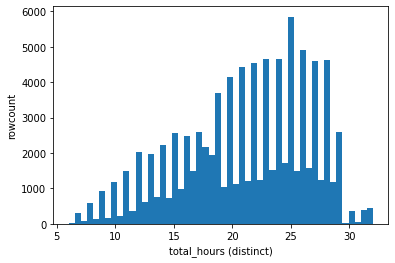

In [8]:
# Group rows by contract "total_hours" and plot the distribution
X_train_window_size_5_grouped = X_train_window_size_5.groupby("total_hours").size().reset_index()
X_train_window_size_5_grouped.rename(columns={0: "rowcount"}, inplace=True)

plt.hist(X_train_window_size_5["total_hours"], label="Count of Rows", bins=50)
plt.xlabel("total_hours (distinct)")
plt.ylabel("rowcount")
plt.show()

## 2.3.Plot trading features 
This step visualizes the trading data specifically. Shown in the graphs below, the open, high, low and close price features resemble sound waves when plotted against the contract "total_hours" with some clearly visible extreme values. Trading volumns share an extreme peak for some contracts with around 11.6 hours.

In [9]:
#First create our helper models to plot the data
def plot_subplots(dataframe: pd.DataFrame, title: str):
    """
    Draws one subplot for each of the columns in the DataFrame.
    """
    
    fig, axes = plt.subplots(nrows=len(dataframe.columns), figsize=(20,20))
    labels = list(dataframe.columns)

    for idx, row in enumerate(axes):
        y = dataframe.iloc[:, idx]
        row.plot(y, label=y.name)
        row.set_ylabel(labels[idx])

    fig.set_facecolor("grey")
    fig.suptitle(title, size=15, y=0.9)
    plt.show()

def plot_subplots_wrapper(
    dataframe: pd.DataFrame,
    title: str,
    labels: list = ["open", "high", "low", "close", "volume", "minutes"]
    ):
    """
    Calls the 'plot_subplots' function for each label provided in labels and selects columns that start with the label.
    """

    #df = dataframe.copy()
    for label in labels:
        print(f"Plots for {label}:")
        title = title + f" {label}"
        plot_subplots(dataframe.loc[:,dataframe.columns.str.startswith(label)], title)

In [ ]:
# Plotting all trading features by contract
df_to_plot = X_train_window_size_5.copy()
title = "General Plots for all data:"
plot_subplots_wrapper(df_to_plot, title)

In [ ]:
# Plotting all trading features from only the first 20 rows by contract
df_to_plot = X_train_window_size_5.copy()
title = "General Plots for just the first 20 Rows:"
plot_subplots_wrapper(df_to_plot.iloc[:20, :].reset_index(), title)

## 2.4.Plot correlation matrix
The heatmap below reveals that delivery-related features strongly  correlated with last-trade-related features on the daily level. Also, the sin & cos transformations are highly correlated with their corresponding original features. The "minutes" columns at different time steps are also strongly correlated with each other, which is only natrual as these columns have a linear relationship. Similar correlations can also be seen among the trading price features between each "steps" pairs as the data has a sliding time window structure. 

In [ ]:
plt.figure(figsize=(30,30))
full_train_window_size_5 = X_train_window_size_5.copy()
full_train_window_size_5["TARGET"] = y_train_window_size_5["y"]
sns.heatmap(full_train_window_size_5.corr(), annot=False, linewidths = 2, square= True, cmap="coolwarm")
plt.show()

# <b>3.Conventional ML models</b>
<b>In the third part, conventional ML models are used to make predictions, serving as a baseline to be compared with DL approaches. </b>


## <b>3.1.Preprocessing the data</b>

### Make data tree-friendly: sin/cos features retransformation to make them work for tree-based approaches
Tree-based algorithms like Random Forest and Boosted Trees build their split rules according to one feature at a time. The cosine-sine transformation of features created 2 columns for every cyclical feature. If possible, we should retransform these 2 features to the original values to increase the chance of higher accuracy of the tree-based approaches.

There are 6 features (i.e., dlvry_day, dlvry_weekday, dlvry_hour, lasttrade_day, lasttrade_weekday, lasttrade_hour) encoded using a sine and cosine column respectively.

As one cannot simply solve the underlying sine and cosine transformations to the original value, we tried to reproduce the tranaformation in order to get the original values.

#### "_weekday" features
When we look at the values for the dlvry_weekday, we can see that there are 7 unique values, corresponding to the days of the week.

,dlvry_weekday_sin,dlvry_weekday_cos,count
0,-0.974928,-0.222521,12722
1,-0.781831,0.623490,12738
2,-0.433884,-0.900969,13163
3,0.000000,1.000000,12923
4,0.433884,-0.900969,13283
5,0.781831,0.623490,13156
6,0.974928,-0.222521,13527


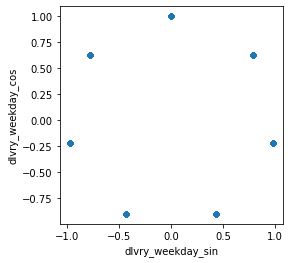

In [13]:
# look at unique values
display(X_train_window_size_5.groupby(['dlvry_weekday_sin', 'dlvry_weekday_cos']).size().reset_index().rename(columns={0:'count'}))

# plot sample of values
X_train_window_size_5.sample(500).plot.scatter('dlvry_weekday_sin','dlvry_weekday_cos').set_aspect('equal')

With that information, we can calculate our own sine and cosine features and create a mapping which is to be used for creating the original feature column for days of the week.

In [14]:
days_in_a_week = 7

mapping_day_of_week = {}

# apply cosine and sine transformaiton for every day of the week
for i in range(0, days_in_a_week):
    mapping_day_of_week[(round(np.sin(2*np.pi*i/days_in_a_week), 5), round(np.cos(2*np.pi*i/days_in_a_week), 5))] = i

mapping_day_of_week

{(-0.97493, -0.22252): 5,
 (-0.78183, 0.62349): 6,
 (-0.43388, -0.90097): 4,
 (0.0, 1.0): 0,
 (0.43388, -0.90097): 3,
 (0.78183, 0.62349): 1,
 (0.97493, -0.22252): 2}

In [15]:
# create function to convert sine- and cosine-transformed values back
def convert_weekday(sin, cos):
    """Return original value from sine- and cosine-transformed values

    Arguments:
    sin -- sine-transformed value
    cos -- cosine-transformed value"""
    weekday = mapping_day_of_week[(round(sin, 5), round(cos, 5))]
    return weekday

#### "_hour" features
When we look at the values for the dlvry_hour, we can see that there are most likely 24 possible values (points are distributed like a 24h clock, corresponding to the hours of the day.

,lasttrade_hour_sin,lasttrade_hour_cos,count
0,-1.000000e+00,-1.836970e-16,902
1,-9.659258e-01,-2.588190e-01,1198
2,-9.659258e-01,2.588190e-01,570
3,-8.660254e-01,5.000000e-01,3792
4,-8.660254e-01,-5.000000e-01,1145
5,-7.071068e-01,7.071068e-01,6446
6,-7.071068e-01,-7.071068e-01,1480
7,-5.000000e-01,8.660254e-01,6638
8,-5.000000e-01,-8.660254e-01,1820
9,-2.588190e-01,9.659258e-01,6627


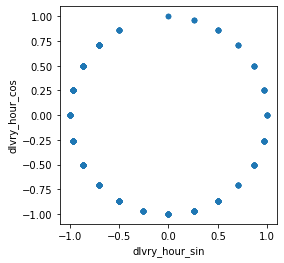

In [16]:
# look at unique values
hours = X_train_window_size_5.groupby(['lasttrade_hour_sin','lasttrade_hour_cos']).size().reset_index().rename(columns={0:'count'})
hours[["lasttrade_hour_sin", "lasttrade_hour_cos"]].round(5)
display(hours)

# plot sample of values
X_train_window_size_5.sample(500).plot.scatter('dlvry_hour_sin','dlvry_hour_cos').set_aspect('equal')

With that information, we can calculate our own sine and cosine features and create a mapping which is to be used for creating the original feature column for hours of the day.

In [17]:
hours_in_a_day = 24

mapping_hour_of_day = {}

# apply cosine and sine transformaiton for every hour of the day
for i in range(0, hours_in_a_day):
    mapping_hour_of_day[(round(np.sin(2*np.pi*i/hours_in_a_day), 5), round(np.cos(2*np.pi*i/hours_in_a_day), 5))] = i
                            
mapping_hour_of_day    

{(-1.0, -0.0): 18,
 (-0.96593, -0.25882): 17,
 (-0.96593, 0.25882): 19,
 (-0.86603, -0.5): 16,
 (-0.86603, 0.5): 20,
 (-0.70711, -0.70711): 15,
 (-0.70711, 0.70711): 21,
 (-0.5, -0.86603): 14,
 (-0.5, 0.86603): 22,
 (-0.25882, -0.96593): 13,
 (-0.25882, 0.96593): 23,
 (0.0, -1.0): 12,
 (0.0, 1.0): 0,
 (0.25882, -0.96593): 11,
 (0.25882, 0.96593): 1,
 (0.5, -0.86603): 10,
 (0.5, 0.86603): 2,
 (0.70711, -0.70711): 9,
 (0.70711, 0.70711): 3,
 (0.86603, -0.5): 8,
 (0.86603, 0.5): 4,
 (0.96593, -0.25882): 7,
 (0.96593, 0.25882): 5,
 (1.0, 0.0): 6}

In [18]:
# create function to convert sine- and cosine-transformed values back
def convert_hour(sin, cos):
    hour = mapping_hour_of_day[(round(sin, 5), round(cos, 5))]
    return hour

#### "_day" features
When we look at the values for the dlvry_day, we can see that there is no obvious patterns like we observed for the _hour and _weekday features.

,dlvry_day_sin,dlvry_day_cos
0,-0.99872,-0.05065
1,-0.99452,0.10453
2,-0.99452,-0.10453
3,-0.98847,0.15143
4,-0.96808,-0.25065
...,...,...
77,0.98847,0.15143
78,0.99452,0.10453
79,0.99452,-0.10453
80,0.99872,-0.05065


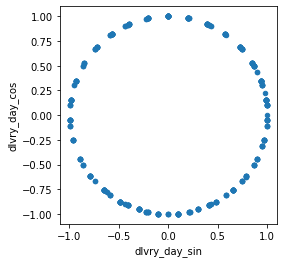

In [19]:
# look at unique values
year_days = X_train_window_size_5.groupby(['dlvry_day_sin','dlvry_day_cos']).size().reset_index().rename(columns={0:'count'})
year_days = year_days[['dlvry_day_sin','dlvry_day_cos']].round(5)
display(year_days)

# plot sample of values
X_train_window_size_5.sample(500).plot.scatter('dlvry_day_sin','dlvry_day_cos').set_aspect('equal')

Intuitively, we might assume that the transformation is based on 365 days in a year, but creating the respective mapping does not yield matches (see below), so we couldn't reproduce the sine and cosine features for the _day features.

In [20]:
days_in_a_year = 365

mapping_day = {}

for i in range(0, days_in_a_year):
    mapping_day[(round(np.sin(2*np.pi*i/days_in_a_year), 5), round(np.cos(2*np.pi*i/days_in_a_year), 5))] = i

# check whether there is a match with randomly picked values from the unique values above
try: 
    mapping_day[(0.98847, 0.15143)]
except KeyError:
    print("There is no match")

There is no match


### Transformation function for tree-based models

In [21]:
def tree_transform(df, drop_day=True):
    """Return tree-friendly data with cos and sin features transformed back to original values

    Arguments:
    df -- dataset
    drop_day -- _day features cannot be transformed back, can be dropped or kept"""
    # create new columns for original values
    data = df.copy()
    data["dlvry_weekday"] = data.apply(lambda x: convert_weekday(x['dlvry_weekday_sin'], x['dlvry_weekday_cos']), axis=1)
    data["lasttrade_weekday"] = data.apply(lambda x: convert_weekday(x['lasttrade_weekday_sin'], x['lasttrade_weekday_cos']), axis=1)
    data["dlvry_hour"] = data.apply(lambda x: convert_hour(x['dlvry_hour_sin'], x['dlvry_hour_cos']), axis=1)
    data[["lasttrade_hour"]] = data.apply(lambda x: convert_hour(x['lasttrade_hour_sin'], x['lasttrade_hour_cos']), axis=1)

    # drop redundant sine and cosine features
    data = data.drop(['dlvry_weekday_sin', 'dlvry_weekday_cos', 'lasttrade_weekday_sin', 
                      'lasttrade_weekday_cos', 'dlvry_hour_sin', 'dlvry_hour_cos', 
                      'lasttrade_hour_sin', 'lasttrade_hour_cos'], axis=1)
    # drop _day features as we couldn't transform them back
    if drop_day:
        data = data.drop(['dlvry_day_cos', 'dlvry_day_sin', 'lasttrade_day_sin', 'lasttrade_day_cos'], axis=1)

    return data

In [22]:
# create tree-friendly datasets
X_train_window_size_5_tree = tree_transform(X_train_window_size_5)
X_valid_window_size_5_tree = tree_transform(X_valid_window_size_5)
X_test_window_size_5_tree = tree_transform(X_test_window_size_5)

### Data Normalization

In [23]:
scaler = MinMaxScaler()
X_train_window_size_5[X_train_window_size_5.columns[17:]] = scaler.fit_transform(X_train_window_size_5[X_train_window_size_5.columns[17:]])
X_valid_window_size_5[X_valid_window_size_5.columns[17:]] = scaler.transform(X_valid_window_size_5[X_valid_window_size_5.columns[17:]])
X_test_window_size_5[X_test_window_size_5.columns[17:]] = scaler.transform(X_test_window_size_5[X_test_window_size_5.columns[17:]])

#Quick note: It seems like the results are getting worse when normalizing the input set X

### Evaluation Functions: MAE

In [24]:
def evaluate_model(model, X_test, y_test_true):
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test_true, predictions)
    print("Mean absolut error on test:", mae)
    return mae

In [15]:
def evaluate_3Dmodel(model, X_test, y_test_true):
    predictions = model.predict(X_test)
    predictions = predictions[:, -1]
    mae = mean_absolute_error(y_test_true, predictions)
    print("Mean absolut error on test:", mae)
    return mae

## <b>3.2.Dummy regressor</b>
Takeaways:

In [25]:
# Modeling
dummy_model = DummyRegressor()
dummy_model.fit(X_train_window_size_5, y_train_window_size_5)

# Evaluate model performance
result = evaluate_model(dummy_model, X_test_window_size_5, y_test_window_size_5)

Mean absolut error on test: 2.258751650277334


## <b>3.3.Linear Regression</b>
As expected, the linear models performed poorly for our data, as indicated by the R2 scores for both degree 1 and degree 2 models. The near 0 R2 scores for both validation and testing suggest that dependent variable cannot be explained by our data. Even though in the plots, the predicted y basically covered the actual y, the non-linear nature of our data cannot be captured by linear models. Due to the computational limitation, we only include the degree 2 polynomial regression, which has already served our purpose. 

In [26]:
# Modify the helper functions specifically for the linear models
# Function to perform Cross Validation on Linear Models
def get_cv_scores(model, X_train, y_train):
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    print('CV Mean of R2: ', np.mean(scores))
    print('CV STD of R2: ', np.std(scores))

# Function to evaluate Linear Models with plots
def evaluate_valid(model, X_valid, y_valid, X_test, y_test):
    predictions_valid = model.predict(X_valid)
    mae_valid = mean_absolute_error(y_valid, predictions_valid)
    r2_valid = r2_score(y_valid, predictions_valid)
    print("Validation MAE:", mae_valid)
    print("Validation R2:", r2_valid)

    predictions_test = model.predict(X_test)
    mae_test = mean_absolute_error(y_test, predictions_test)
    r2_test = r2_score(y_test, predictions_test)
    print("Test MAE:", mae_test)
    print("Test R2:", r2_test)
    
    fig=plt.figure()
    ax=fig.add_axes([0,0,1,1])
    ax.scatter(y_valid, predictions_valid, color='r', label='valid set', alpha=0.2)
    ax.scatter(y_test, predictions_test, color='b', label='test set', alpha=0.2)
    ax.set_title('Distributions of predicted and real Y')
    ax.set_xlabel('Actual Y')
    ax.set_ylabel('Predicted Y')
    ax.legend()

CV Mean of R2:  -0.002444375793037956
CV STD of R2:  0.011855571850617105
Validation MAE: 2.561283916269669
Validation R2: -0.00694251426219572
Test MAE: 2.2812644117528604
Test R2: -0.004568293422968495
Independent term in the linear model:  [15.07411672]
Estimated coefficients in the linear regression: 
 [[ 6.89081868e-03 -9.88587493e-03 -1.45634910e-01 -1.46917649e-01
   1.15859755e-01  1.91936020e-02  3.09468599e-02  1.18505900e-02
  -4.59516082e-03  2.98062540e-02  2.90961513e-01  1.92219458e-01
  -7.20698835e-02  1.10265956e-01 -3.37399818e-03 -1.19450344e-01
   7.28990918e-03 -4.51763147e+00  8.80925167e+00  5.79993575e+00
  -6.75171850e+00 -1.95555714e-01 -3.58314416e-02 -5.81054999e+00
   1.66483050e+01  4.09302290e+00 -6.66822421e+00 -5.22698550e+00
  -3.58314416e-02 -6.30042715e+00  2.26504993e+01  1.90344269e-01
  -9.40568707e+00 -1.88348195e+01 -3.58314416e-02 -1.67705405e+00
   1.63941172e+01  3.30408005e+00 -2.84623445e+01 -2.42397813e+01
  -3.58314416e-02]]


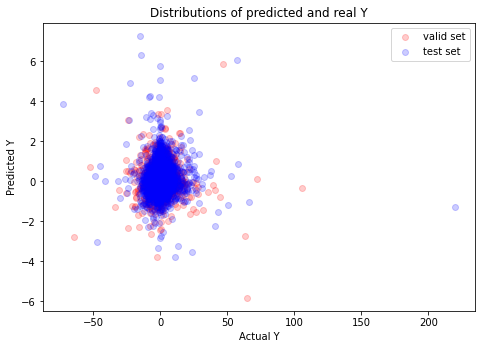

In [27]:
# Direct Linear Modling on Original Data 
model_lr = LinearRegression(copy_X=True, n_jobs=100)
model_lr.fit(X_train_window_size_5, y_train_window_size_5)

# Evaluate model performance
get_cv_scores(model_lr, X_train_window_size_5, y_train_window_size_5)
evaluate_valid(model_lr, X_valid_window_size_5, y_valid_window_size_5, X_test_window_size_5, y_test_window_size_5)
print('Independent term in the linear model: ', model_lr.intercept_)
print('Estimated coefficients in the linear regression: \n', model_lr.coef_)

CV Mean of R2:  -6.259556302367364e+16
CV STD of R2:  1.2266999010145466e+17
Validation MAE: 2.7870416250816885
Validation R2: -0.21708092496475162
Test MAE: 2.4663861117270316
Test R2: -0.07260491721297702


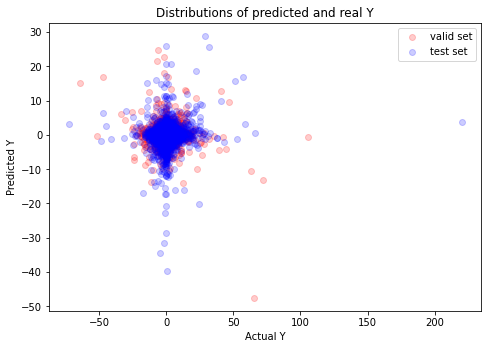

In [28]:
# Polynomial Regression (Degree=2) 
# Transformation of X_train/valid/test datasets
polynomial_features= PolynomialFeatures(degree=2)
X_train_5_poly = polynomial_features.fit_transform(X_train_window_size_5)
X_valid_5_poly = polynomial_features.fit_transform(X_valid_window_size_5)
X_test_5_poly = polynomial_features.fit_transform(X_test_window_size_5)

# Modeling
model_lr = LinearRegression(normalize=True, copy_X=True, n_jobs=100)
model_lr.fit(X_train_5_poly, y_train_window_size_5)
get_cv_scores(model_lr, X_train_5_poly, y_train_window_size_5)

# Evaluate model performance
evaluate_valid(model_lr, X_valid_5_poly, y_valid_window_size_5, X_test_5_poly, y_test_window_size_5)

## <b>3.4.Random Forrest</b>
- **Intro**:

    The Random Forest method fits on the training data using an ensemble of decision trees. An important feature of the model is that it helps avoid overfitting by building each of the tree with a sample of data points as well as a sample of the features of the original training dataset.

- **Input data**:

    > Training dataset: `X_train_window_size_5_tree` and `y_train_window_size_5`\
    > Validation dataset: `X_valid_window_size_5_tree` and `y_valid_window_size_5`\
    > Testing dataset: `X_test_window_size_5_tree` and `y_test_window_size_5`
    
    Apart from normalization, the datasets used for Random Forest modelling have also been transformed in terms of their datetime columns, such as for the variable `lasttrade_weekday`. These columns originally consisted of two sets of variables to express a certain datetime point, which has been preprocessed and converted back to their original value.

- **Architecture**:

    After comparing the models' performance on the validation dataset using GridSearchCV, the best combination of parameters for the Random Forest Regressor is:
    | Parameter name    | Value  |
    |-------------------|--------|
    | n_estimators      | 500    |
    | max_features      | 'sqrt' |
    | min_samples_split | 10     |
    
It is worth noting that our group has also tried dropping features that are deemed the least important by the Random Forest model after performing the Grid Search, and there seemed to be little improvement in the model's performance, which is why this part has been excluded here.

In [22]:
# Modeling
rfmodel = RandomForestRegressor(random_state=3315, 
                                max_depth=6,
                                n_estimators=500,
                                max_features='sqrt',
                                min_samples_split=10,
                                criterion='mse', n_jobs=-1)
rfmodel.fit(X_train_window_size_5_tree, y_train_window_size_5)

# Evaluate model performance
result = evaluate_model(rfmodel, X_test_window_size_5_tree, y_test_window_size_5)

Mean absolut error on test: 2.276691339825479


- **Brief summary**:

    > As shown in the cell below, the Random Forest model's performance on the test dataset is 2.2767 in terms of MAE.
    
    ___Limitations___: 
    
    While Random Forest takes advantage of the power of ensemble, which helps avoid overfitting, it simply aggregates all the individual decision trees by training them in parallel. In other words, the trees within the Random Forest model are independent from each other and thus can't learn from each other. To address this disadvantage, we have also tried ensemble of boosted trees as shown in the following section.

## <b>3.5.CatBoost and XGBoost</b>
Takeaways:

### LightGBM Model

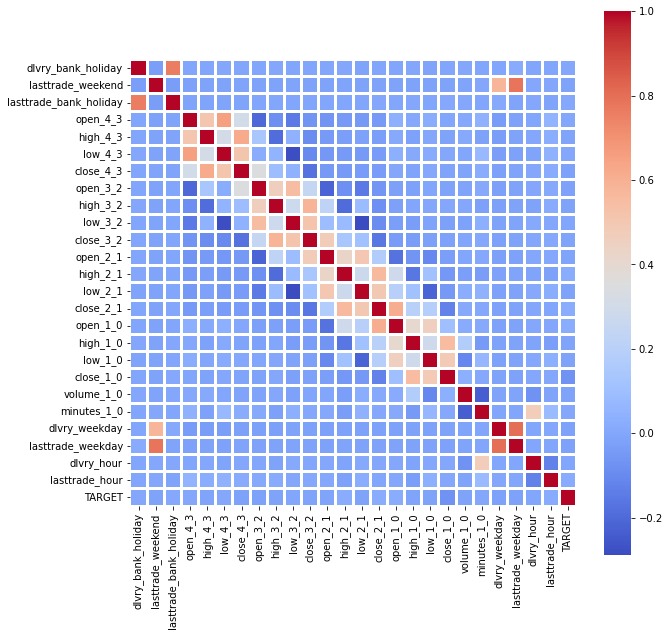

In [27]:
# Drop some features
X_train_window_size_5_tree = X_train_window_size_5_tree.drop(['total_hours','minutes_4_3', 'minutes_3_2', 'minutes_2_1', 'dlvry_weekend', 'volume_4_3','volume_3_2', 'volume_2_1'], axis=1)
X_valid_window_size_5_tree = X_valid_window_size_5_tree.drop(['total_hours','minutes_4_3', 'minutes_3_2', 'minutes_2_1', 'dlvry_weekend', 'volume_4_3','volume_3_2', 'volume_2_1'], axis=1)
X_test_window_size_5_tree = X_test_window_size_5_tree.drop(['total_hours', 'minutes_4_3', 'minutes_3_2', 'minutes_2_1', 'dlvry_weekend', 'volume_4_3','volume_3_2', 'volume_2_1'], axis=1)

# Plot
plt.figure(figsize=(10,10))
full_train_window_size_5 = X_train_window_size_5_tree.copy()
full_train_window_size_5["TARGET"] = y_train_window_size_5["y"]
sns.heatmap(full_train_window_size_5.corr(), annot=False, linewidths = 2, square= True, cmap="coolwarm")
plt.show()

In [28]:
# Process data
train_data = lgb.Dataset(X_train_window_size_5_tree, label=y_train_window_size_5)
valid_data = lgb.Dataset(X_valid_window_size_5_tree, label=y_valid_window_size_5)
test_data = lgb.Dataset(X_test_window_size_5_tree, label=y_test_window_size_5)

# Modeling
param = {'num_leaves': 38, 'objective': 'regression_l1', 'metric': 'mae'}
num_round =17
bst = lgb.train(param, train_data, num_round, valid_sets=[valid_data])

# Evaluate model performance
result = evaluate_model(bst, X_test_window_size_5_tree, y_test_window_size_5)

[1]	valid_0's l1: 2.55466
[2]	valid_0's l1: 2.55436
[3]	valid_0's l1: 2.55373
[4]	valid_0's l1: 2.55288
[5]	valid_0's l1: 2.55318
[6]	valid_0's l1: 2.55347
[7]	valid_0's l1: 2.55335
[8]	valid_0's l1: 2.55299
[9]	valid_0's l1: 2.55306
[10]	valid_0's l1: 2.55255
[11]	valid_0's l1: 2.55216
[12]	valid_0's l1: 2.55203
[13]	valid_0's l1: 2.5511
[14]	valid_0's l1: 2.55088
[15]	valid_0's l1: 2.55049
[16]	valid_0's l1: 2.55001
[17]	valid_0's l1: 2.55073
Mean absolut error on test: 2.2483066265867726


## <b>3.6.Support Vector Regression</b>
- **Intro**:

    The Support Vector Regression model utilizes the kernel trick to project the original dataset to a higher dimension in an efficient way. A main advantage of the model is its ability to tolerate errors within a certain range, which allows the model to become robust.

- **Input data**:

    The input data of the model has been normalized.
    
    > Training dataset: `X_train_window_size_5` and `y_train_window_size_5`\
    > Validation dataset: `X_valid_window_size_5` and `y_valid_window_size_5`\
    > Testing dataset: `X_test_window_size_5` and `y_test_window_size_5`
    
- **Architecture**:

    After comparing the models' performance on the validation dataset using GridSearchCV, the best combination of parameters for the Support Vector Regression model is:
    | Parameter name    | Value  |
    |-------------------|--------|
    | kernel      | 'poly'    |
    | C      | 20' |

In [24]:
# Modeling
svrmodel = SVR(kernel='poly', C=20)
svrmodel.fit(X_train_window_size_5, y_train_window_size_5)

# Evaluate model performance
result = evaluate_model(svrmodel, X_test_window_size_5, y_test_window_size_5)

Mean absolut error on test: 2.260098588031554


- **Brief summary**:

    > As shown in the cell above, the Support Vector Regression model's performance on the test dataset is 2.26 in terms of MAE.
    
    ___Limitations___: 
    
    While Support Vector Regressor manages to introduce non-linearity by projecting the original dataset to a higher dimension space and does it in an effective way, it is relatively time consuming and requires much more resources compared to other models, especially when training on large datasets.

## <b>3.7.KNN</b>
The optimal k was found doing a grid search for `range(3, 25)`.  

For this 'classic' approach, the train and valid set will be put together to make use of cross-validation.

In [29]:
X_train_window_size_5_classic = X_train_window_size_5.copy().append(X_valid_window_size_5)
y_train_window_size_5_classic = y_train_window_size_5.copy().append(y_valid_window_size_5)

minmax_transformer_classic = Pipeline(steps=[
        ('minmax', MinMaxScaler())])

preprocessor_window_size_5_classic = ColumnTransformer(
        remainder='passthrough', #passthough features not listed
        transformers=[
            ('mm', minmax_transformer_classic , [X_train_window_size_5_classic.columns[1], *[*X_train_window_size_5_classic.columns[17:]]])
        ])


preprocessor_window_size_5_classic.fit(X_train_window_size_5, y_train_window_size_5)
X_train_window_size_5_classic_norm = preprocessor_window_size_5_classic.transform(X_train_window_size_5_classic)
X_test_window_size_5_classic_norm = preprocessor_window_size_5_classic.transform(X_test_window_size_5)

In [30]:
class Knn:

    def __init__(self,
                 X_train: pd.DataFrame,
                 X_test: pd.DataFrame,
                 y_train: pd.DataFrame,
                 y_test: pd.DataFrame,
                 k: int):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.k = k
        self.model = KNeighborsRegressor(n_neighbors=self.k, n_jobs=-1)
        self.mae_scorer = make_scorer(mean_absolute_error)
    
    def get_cv_scores(self):
        return cross_val_score(self.model, self.X_train, self.y_train, cv=5, scoring=self.mae_scorer)

    def fit(self):
        self.model.fit(self.X_train, self.y_train)

    def predict(self):
        predictions = self.model.predict(self.X_test)
        return predictions

    def go(self):
        cv_scores = self.get_cv_scores()
        self.fit()
        predictions = self.predict()
        return cv_scores, predictions, self.model

In [31]:
knn_5 = Knn(
    X_train_window_size_5_classic_norm,
    X_test_window_size_5_classic_norm,
    y_train_window_size_5_classic,
    y_test_window_size_5,
    k=3
)

knn_cv_scores_5, knn_predictions_5, knn_model_5 = knn_5.go()

CV Scores for KNN

In [32]:
knn_cv_scores_5

array([2.16796654, 2.01141579, 2.32734974, 2.23319267, 2.45716533])

Prediction Scores for KNN

In [33]:
knn_predictions_5

array([[-0.15333333],
       [-0.15333333],
       [ 0.39      ],
       ...,
       [ 0.63      ],
       [ 1.07      ],
       [ 1.07      ]])

# <b>4.Creating DL models</b>
<b>In this part, we employed multiple DL methods. </b>


## <b>4.1.Mulit-Layer Perceptron</b>
For the MLP, the architecture seemed to be rather irrelevant. Generally speaking, simpler architectures with less neurons seemed to work as well as more complex architectures with several hidden layers and/or a large number of neurons. In total, a few hundred neurons overall were enough. Dropout, LR Scheduling and Adam optimizer created the best results.  
We also found that higher batch sizes decreased the MAE.  
One interesting finding is that the performance on the validation set would not change after 2-3 epochs. Additionally, the performance on the test set was always better than the performance on the validation set.

In [34]:
class Mlp:
    """
    Creates a multilayer-perceptron model.
    """
    def __init__(self, 
                 X_train: pd.DataFrame, 
                 X_valid: pd.DataFrame, 
                 X_test: pd.DataFrame, 
                 y_train: pd.DataFrame, 
                 y_valid: pd.DataFrame, 
                 y_test: pd.DataFrame, 
                 params: dict, 
                 layers: list, 
                 dropout: bool,
                 schedulerthresh: int,
                 optimizer,
                 earlystopping: int
                 ):
        self.X_train = X_train
        self.X_valid = X_valid
        self.X_test = X_test
        self.y_train = y_train
        self.y_valid = y_valid
        self.y_test = y_test
        self.params = params
        self.layers = layers
        self.dropout = dropout
        self.schedulerthresh = schedulerthresh
        self.optimizer = optimizer
        self.earlystopping = earlystopping
        self.model = Sequential()

    def compile_model(self):
        be.clear_session()
        self.model.add(Input(shape=(self.X_train.shape[1])))
        for i in range(len(self.layers)):
            self.model.add(Dense(self.layers[i], activation="relu"))
            if self.dropout:
                self.model.add(Dropout(rate=self.dropout))
        self.model.add(Dense(1, activation="linear"))
        optimizer = self.optimizer
        self.model.compile(loss='mean_absolute_error', optimizer=optimizer)
        return self.model
        
    def fit_model(self):
        callbacks = []
        if self.scheduler:
            callbacks.append(LearningRateScheduler(self.scheduler))
        if self.earlystopping:
            callbacks.append(EarlyStopping(monitor='loss', patience=self.earlystopping))
        history = self.model.fit(x=self.X_train,y=self.y_train, batch_size=self.params["BATCH_SIZE"], validation_data=(self.X_valid,self.y_valid), epochs=self.params["EPOCHS"], callbacks=callbacks, verbose=1, shuffle=False)
        return history, self.model

    def evaluate_model(self):
        eval_score = self.model.evaluate(self.X_test, self.y_test.to_numpy())
        return eval_score, self.model

    def predict(self):
        return self.model.predict(self.X_test)
      
    def go(self):
        self.compile_model()
        history, _ = self.fit_model()
        eval_score, _ = self.evaluate_model()
        predictions = self.predict()
        return history, eval_score, predictions, self.model
        
    def scheduler(self, epoch, lr):
        if self.schedulerthresh:
            thresh = self.schedulerthresh
        else:
            thresh = 5
        if epoch < thresh:
            return lr
        else:
            return lr*exp(-0.1)


### Creating best model for MLP

In [35]:
params = {
    "BATCH_SIZE": 2048, 
    "EPOCHS": 10, 
    "LEARNING_RATE": 0.0005}
layers = [300, 100]
dropout = 0.25
scheduler = 5
optimizer = Adam(learning_rate=0.0005)
earlystopping = 3

mlp_5 = Mlp(
    X_train_window_size_5,
    X_valid_window_size_5,
    X_test_window_size_5,
    y_train_window_size_5,
    y_valid_window_size_5,
    y_test_window_size_5,
    params,
    layers,
    dropout,
    scheduler,
    optimizer,
    earlystopping
)
mlp_history_5, mlp_eval_score_5, mlp_predictions_5, mlp_model_5 = mlp_5.go()

Epoch 1/10
45/45 [==============================] - 1s 6ms/step - loss: 1.9087 - val_loss: 2.5613
Epoch 2/10
45/45 [==============================] - 0s 3ms/step - loss: 1.7933 - val_loss: 2.5571
Epoch 3/10
45/45 [==============================] - 0s 2ms/step - loss: 1.7768 - val_loss: 2.5554
Epoch 4/10
45/45 [==============================] - 0s 2ms/step - loss: 1.7728 - val_loss: 2.5552
Epoch 5/10
45/45 [==============================] - 0s 3ms/step - loss: 1.7718 - val_loss: 2.5551
Epoch 6/10
45/45 [==============================] - 0s 3ms/step - loss: 1.7713 - val_loss: 2.5551
Epoch 7/10
45/45 [==============================] - 0s 3ms/step - loss: 1.7712 - val_loss: 2.5552
Epoch 8/10
45/45 [==============================] - 0s 3ms/step - loss: 1.7711 - val_loss: 2.5551
Epoch 9/10
45/45 [==============================] - 0s 3ms/step - loss: 1.7710 - val_loss: 2.5551
Epoch 10/10
335/335 [==============================] - 1s 2ms/step - loss: 2.2551


Evaluation Score of MLP

In [36]:
mlp_eval_score_5

2.255129814147949

Plotting the Convergence process

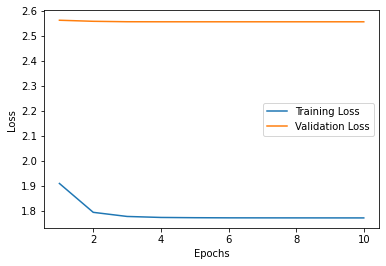

In [38]:
loss_values = mlp_history_5.history['loss']
val_loss_values = mlp_history_5.history['val_loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.plot(epochs, val_loss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## <b>4.2.Transform data to 3D for Recurrent Neural Networks</b>

In [39]:
################### Add "Drop feature" option based on Jacob and Jamie's version
def unflatten_all(data, window_size, drop_features_list=None):
    """Return 3D data for all features (except minutes left) 
    to make the data suitable for recurrent neural networks

    Arguments:
    data -- predictor data after renaming and normalization
    window_size -- either 5 or 15
    """
    # Add option to drop a list of features 
    if drop_features_list == None:
        drop_features_list = []
    else:
        data = data.drop(drop_features_list, axis=1)

    # empty variable to hold final stacked 3D array
    X_all_feat = []

    # copy every non-time-series feature to get the right shape
    feature_count = 17-len(drop_features_list)
    for feature in data.iloc[:,:feature_count].columns:
        X_feat = pd.concat([data[feature]]*(window_size - 1), axis=1)
        X_all_feat.append(X_feat)
    
    # process open, high, low, close and volume features
    X = data.iloc[:,feature_count:] 
    # drop minutes left feature as it is a linear function of time
    minute_col = [col for col in X.columns if 'minutes' in col]
    X = X.drop(minute_col, axis = 1)

    # separate data per feature
    open_col = [col for col in X.columns if 'open' in col]
    X_open = X[open_col]
    high_col = [col for col in X.columns if 'high' in col]
    X_high = X[high_col]
    low_col = [col for col in X.columns if 'low' in col]
    X_low = X[low_col]
    close_col = [col for col in X.columns if 'close' in col]
    X_close = X[close_col]
    vol_col = [col for col in X.columns if 'volume' in col]
    X_vol = X[vol_col]
    X_ts = [X_open, X_high, X_low, X_close, X_vol]
    X_all_feat.extend(X_ts)

    # stack data
    X = np.stack(X_all_feat, axis = 2)

    return X

In [40]:
drop_features_list = ['dlvry_day_sin', 'dlvry_day_cos', 'dlvry_weekday_sin', 'dlvry_weekday_cos', 'dlvry_hour_sin', 'dlvry_hour_cos',
                      'lasttrade_day_sin', 'lasttrade_day_cos', 'lasttrade_weekday_sin', 'lasttrade_weekday_cos', 'lasttrade_hour_sin', 
                      'lasttrade_weekend','lasttrade_bank_holiday', 'lasttrade_hour_cos']
X_train_unflatten_all_5 = unflatten_all(X_train_window_size_5, 5, drop_features_list)
X_valid_unflatten_all_5 = unflatten_all(X_valid_window_size_5, 5, drop_features_list)
X_test_unflatten_all_5 = unflatten_all(X_test_window_size_5, 5, drop_features_list)
np.shape(X_train_unflatten_all_5), np.shape(X_valid_unflatten_all_5), np.shape(X_test_unflatten_all_5)

((91512, 4, 8), (4817, 4, 8), (10704, 4, 8))

## <b>4.3.Convolutional Neural Network</b>
- **Intro**:

   A Convolutional Neural Network model involves multiple filters that can be used to capture complex patterns in the datasets. One of its distinct features is its parameter sharing, which can greatly increase its efficiency.

- **Input data**:

    The input data of the model has been normalized and rolled into a form of 3D data.
    
    > Training dataset: `X_train_unflatten_all_5` and `y_train_window_size_5`\
    > Validation dataset: `X_valid_unflatten_all_5` and `y_valid_window_size_5`\
    > Testing dataset: `X_test_unflatten_all_5` and `y_test_window_size_5`
    
- **Architecture**:

    When increasing the complexity of the model (whether by increasing the number of hidden layers or the number of hidden cells), its performance doesn't seem to change. With various experiments, we have arrived at a relatively simple structure that yields similar results to its more complicated alternatives: 2 pairs of Convolutional layers and Max Pooling layers, followed by 2 pairs of fully connected layers and dropout layers.

In [26]:
n_hidden_layers = 2
hidden_layer_size = 40
dropout_rate = 0

BATCH_SIZE = 100
EPOCHS = 20

In [29]:
tf.compat.v1.reset_default_graph()
be.clear_session()

# Define regularizer and initializer
regularizer = tf.keras.regularizers.L2(2.)
initializer = tf.keras.initializers.RandomUniform()

input_shape = np.shape(X_train_unflatten_all_5)
column_count = input_shape[2]

input_layer=Input(shape=(input_shape[1], column_count))
cur_last_layer = input_layer

for l in range(n_hidden_layers):
    cnn_layer=Conv1D(filters=5, kernel_size=2, 
                     input_shape=input_shape[1:],
                     padding='same',
                     kernel_initializer=initializer,
                     kernel_regularizer=regularizer)(cur_last_layer)
    pool = MaxPool1D(pool_size=2, strides=1)(cnn_layer)
    cur_last_layer=pool

for l in range(n_hidden_layers):
    dense = Dense(100, activation='tanh')(cur_last_layer)
    dropout_layer = Dropout(dropout_rate)(dense)
    cur_last_layer=dropout_layer

predictions=Dense(1)(cur_last_layer)

cnn_model=Model(inputs=input_layer, outputs=predictions)
cnn_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4, 22)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 4, 5)              225       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 5)              0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3, 5)              55        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2, 5)              0         
_________________________________________________________________
dense (Dense)                (None, 2, 100)            600       
_________________________________________________________________
dropout (Dropout)            (None, 2, 100)            0     

In [30]:
optimizer = Adam(learning_rate=0.0018)

cnn_model.compile(loss='mean_absolute_error', optimizer=optimizer)

cnn_history = cnn_model.fit(X_train_unflatten_all_5, y_train_window_size_5,
                            validation_data=(X_valid_unflatten_all_5, y_valid_window_size_5),
                            epochs=EPOCHS,
                            batch_size=BATCH_SIZE)

Epoch 1/20
916/916 [==============================] - 20s 6ms/step - loss: 1.7757 - val_loss: 2.5553
Epoch 2/20
916/916 [==============================] - 4s 5ms/step - loss: 1.7709 - val_loss: 2.5551
Epoch 3/20
916/916 [==============================] - 4s 5ms/step - loss: 1.7708 - val_loss: 2.5552
Epoch 4/20
916/916 [==============================] - 4s 5ms/step - loss: 1.7708 - val_loss: 2.5552
Epoch 5/20
916/916 [==============================] - 4s 5ms/step - loss: 1.7709 - val_loss: 2.5554
Epoch 6/20
916/916 [==============================] - 4s 5ms/step - loss: 1.7709 - val_loss: 2.5551
Epoch 7/20
916/916 [==============================] - 4s 5ms/step - loss: 1.7708 - val_loss: 2.5553
Epoch 8/20
916/916 [==============================] - 5s 5ms/step - loss: 1.7709 - val_loss: 2.5552
Epoch 9/20
916/916 [==============================] - 4s 5ms/step - loss: 1.7708 - val_loss: 2.5551
Epoch 10/20
916/916 [==============================] - 4s 5ms/step - loss: 1.7709 - val_loss: 2.555

In [32]:
result = evaluate_3Dmodel(cnn_model, X_test_unflatten_all_5, y_test_window_size_5)

Mean absolut error on test: 2.255178354827305


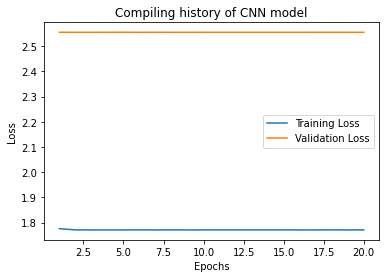

In [33]:
loss_values = cnn_history.history['loss']
val_loss_values = cnn_history.history['val_loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.plot(epochs, val_loss_values, label='Validation Loss')

plt.title("Compiling history of CNN model")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

- **Brief summary**:

    > As shown in the cell above, the performance of the CNN on the test dataset is 2.255 in terms of MAE.
    
    ___Limitations___: 
    
    Generally, it is more common to use CNN in image related problems, therefore, it's not surprising that the model cannot achieve high performance here. Moreover, considering the dimensionality of the data fed into the neural network (with a window size of 5 and therefore 4 "time steps"), the size of kernel that can be used is rather limited.

## <b>4.4.Recurrent Neural Network</b>

### LSTM: Long- Short-Term Memory

- **Intro**:

   A Long- Short-Term Memory model is a type of Recurrent Neural Network that is often used for sequence data such as in time-series and NLP problems. By introducing an additional vector, i.e., the cell state, the model is able to store important information of the past that is helpful for the prediction of the current state (or forget useless information when needed). Since the task we have involve time series data, LSTM seems to be a natural candidate for achieving high performance.

- **Input data**:

    The input data of the model has been normalized and rolled into a form of 3D data.
    
    > Training dataset: `X_train_unflatten_all_5` and `y_train_window_size_5`\
    > Validation dataset: `X_valid_unflatten_all_5` and `y_valid_window_size_5`\
    > Testing dataset: `X_test_unflatten_all_5` and `y_test_window_size_5`
    
- **Architecture**:

    When increasing the complexity of the model (whether by increasing the number of hidden layers or the number of hidden cells), its performance doesn't seem to change. Below is one of the structures that yields similar results to its alternatives, with 3 pairs of LSTM layers and dropout layers followed by 3 pairs of fully connected layers and dropout layers.

In [34]:
n_hidden_layers = 3
hidden_layer_size = 300
dropout_rate = 0.25

BATCH_SIZE = 500
EPOCHS = 20

In [35]:
tf.compat.v1.reset_default_graph()
be.clear_session()

input_shape[2]
column_count = np.shape(X_train_unflatten_all_5)[2]

input_layer=Input(shape=(np.shape(X_train_unflatten_all_5)[1], column_count))
cur_last_layer=input_layer

for l in range(n_hidden_layers):
    hidden_layer=LSTM(hidden_layer_size, return_sequences=True)(cur_last_layer)
    dropout_layer = Dropout(0.5)(hidden_layer)
    cur_last_layer=dropout_layer

for l in range(n_hidden_layers):
    dense = Dense(100, activation='tanh')(cur_last_layer)
    dropout_layer = Dropout(dropout_rate)(dense)
    cur_last_layer=dropout_layer

predictions=Dense(1)(cur_last_layer)

lstm_model=Model(inputs=input_layer, outputs=predictions)
lstm_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4, 22)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 4, 300)            387600    
_________________________________________________________________
dropout (Dropout)            (None, 4, 300)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 4, 300)            721200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 300)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 4, 300)            721200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 300)            0     

In [36]:
optimizer = RMSprop(learning_rate=0.005)
lstm_model.compile(loss='mean_absolute_error', optimizer=optimizer)

lstm_history = lstm_model.fit(X_train_unflatten_all_5, y_train_window_size_5,
                              validation_data=(X_valid_unflatten_all_5, y_valid_window_size_5),
                              epochs=EPOCHS,
                              batch_size=BATCH_SIZE)

Epoch 1/20
184/184 [==============================] - 29s 82ms/step - loss: 1.8798 - val_loss: 2.5572
Epoch 2/20
184/184 [==============================] - 14s 76ms/step - loss: 1.7720 - val_loss: 2.5695
Epoch 3/20
184/184 [==============================] - 14s 77ms/step - loss: 1.7717 - val_loss: 2.5569
Epoch 4/20
184/184 [==============================] - 14s 76ms/step - loss: 1.7718 - val_loss: 2.5564
Epoch 5/20
184/184 [==============================] - 14s 77ms/step - loss: 1.7715 - val_loss: 2.5579
Epoch 6/20
184/184 [==============================] - 14s 78ms/step - loss: 1.7715 - val_loss: 2.5559
Epoch 7/20
184/184 [==============================] - 14s 78ms/step - loss: 1.7716 - val_loss: 2.5556
Epoch 8/20
184/184 [==============================] - 15s 79ms/step - loss: 1.7713 - val_loss: 2.5557
Epoch 9/20
184/184 [==============================] - 15s 80ms/step - loss: 1.7714 - val_loss: 2.5559
Epoch 10/20
184/184 [==============================] - 15s 81ms/step - loss: 1.771

In [37]:
result = evaluate_3Dmodel(lstm_model, X_test_unflatten_all_5, y_test_window_size_5)

Mean absolut error on test: 2.255846573621465


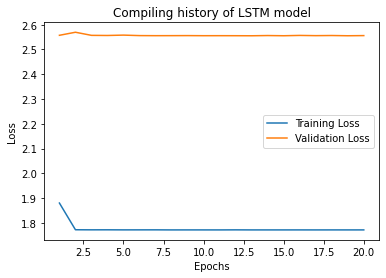

In [38]:
loss_values = lstm_history.history['loss']
val_loss_values = lstm_history.history['val_loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.plot(epochs, val_loss_values, label='Validation Loss')

plt.title("Compiling history of LSTM model")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

- **Brief summary**:

    > As shown in the cell above, the LSTM model's performance on the test dataset is 2.2558 in terms of MAE.
    
    ___Limitations___: 
    
    While the structure of LSTM, especially the introduction of the cell state, allows it to process sequence data better, again, as mentioned above, due to the limitation caused by dimensionality of the input data (with a window size of 5 and therefore 4 "time steps"), the maximum context information that the neural network can store in the cell state is restricted, which is possibly the reason why the network fails to learn much additional information and predict better compared to other models shown above.

### Gated Recurrent Unit

- **Intro**:

   A Gated Recurrent Unit model is another type of Recurrent Neural Network. Compared to LSTM, a GRU neural network has fewer gates and parameters and therefore is more efficient to train.

- **Input data**:

    The input data of the model has been normalized and rolled into a form of 3D data.
    
    > Training dataset: `X_train_unflatten_all_5` and `y_train_window_size_5`\
    > Validation dataset: `X_valid_unflatten_all_5` and `y_valid_window_size_5`\
    > Testing dataset: `X_test_unflatten_all_5` and `y_test_window_size_5`
    
- **Architecture**:

    When increasing the complexity of the model (whether by increasing the number of hidden layers or the number of hidden cells), its performance doesn't seem to change. Below is one of the structures that yields similar results to its alternatives, with 2 pairs of GRU layers and dropout layers followed by 2 pairs of fully connected layers and dropout layers.

In [41]:
n_hidden_layers = 2
hidden_layer_size = 200
dropout_rate = 0.5

BATCH_SIZE = 300
EPOCHS = 20

In [42]:
tf.compat.v1.reset_default_graph()
be.clear_session()

column_count = np.shape(X_train_unflatten_all_5)[2]

input_layer=Input(shape=(np.shape(X_train_unflatten_all_5)[1], column_count))
cur_last_layer=input_layer

for l in range(n_hidden_layers):
    hidden_layer=GRU(hidden_layer_size, return_sequences=True)(cur_last_layer)
    cur_last_layer=hidden_layer

for l in range(n_hidden_layers):
    dense = Dense(100, activation='sigmoid')(cur_last_layer)
    dropout_layer = Dropout(dropout_rate)(dense)
    cur_last_layer=dropout_layer
predictions=Dense(1)(cur_last_layer)

gru_model=Model(inputs=input_layer, outputs=predictions)
gru_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4, 22)]           0         
_________________________________________________________________
gru (GRU)                    (None, 4, 200)            134400    
_________________________________________________________________
gru_1 (GRU)                  (None, 4, 200)            241200    
_________________________________________________________________
dense (Dense)                (None, 4, 100)            20100     
_________________________________________________________________
dropout (Dropout)            (None, 4, 100)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 4, 100)            10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 100)            0     

In [43]:
#For shape remeber, we have a variable defining the "window" and the features in the window...
optimizer = RMSprop(learning_rate=0.0015)
gru_model.compile(loss='mean_absolute_error', optimizer=optimizer)

gru_history = gru_model.fit(X_train_unflatten_all_5, y_train_window_size_5,
                              validation_data=(X_valid_unflatten_all_5, y_valid_window_size_5),
                              epochs=EPOCHS,
                              batch_size=BATCH_SIZE)

Epoch 1/20
306/306 [==============================] - 10s 23ms/step - loss: 1.7964 - val_loss: 2.5552
Epoch 2/20
306/306 [==============================] - 7s 22ms/step - loss: 1.7709 - val_loss: 2.5553
Epoch 3/20
306/306 [==============================] - 7s 22ms/step - loss: 1.7709 - val_loss: 2.5554
Epoch 4/20
306/306 [==============================] - 7s 22ms/step - loss: 1.7709 - val_loss: 2.5553
Epoch 5/20
306/306 [==============================] - 7s 23ms/step - loss: 1.7709 - val_loss: 2.5553
Epoch 6/20
306/306 [==============================] - 6s 21ms/step - loss: 1.7709 - val_loss: 2.5553
Epoch 7/20
306/306 [==============================] - 7s 23ms/step - loss: 1.7709 - val_loss: 2.5551
Epoch 8/20
306/306 [==============================] - 6s 21ms/step - loss: 1.7709 - val_loss: 2.5553
Epoch 9/20
306/306 [==============================] - 7s 23ms/step - loss: 1.7709 - val_loss: 2.5554
Epoch 10/20
306/306 [==============================] - 7s 22ms/step - loss: 1.7709 - val_l

In [44]:
result = evaluate_3Dmodel(gru_model, X_test_unflatten_all_5, y_test_window_size_5)

Mean absolut error on test: 2.2554063179541552


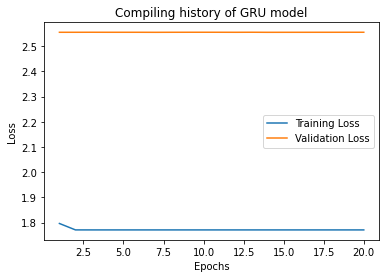

In [46]:
loss_values = gru_history.history['loss']
val_loss_values = gru_history.history['val_loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.plot(epochs, val_loss_values, label='Validation Loss')

plt.title('Compiling history of GRU model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

- **Brief summary**:

    > As shown in the cell above, the GRU model's performance on the test dataset is 2.2554 in terms of MAE.
    
    It is interesting to see that compared to LSTM, GRU yields a slightly better performance on the test set. However, the graphs of the compile histories of both models seem very similar--both show that there is little learning after the first 2 or 3 epochs.
    
    ___Limitations___: 
    
    With fewer parameters and gates in the neural network, while the speed of training has been increased, the complexity that can be captured by GRU is also reduced. While its performance does seem better than LSTM, the difference can also be caused by other random factors.

## <b>4.5.Transformers: Attention is all you need!</b>

In [54]:
X_train_window_size_5 = X_train_window_size_5.drop(['total_hours', 'minutes_4_3', 'minutes_3_2', 'minutes_2_1', 'dlvry_weekend', 'volume_4_3','volume_3_2', 'volume_2_1'], axis=1)
X_valid_window_size_5 = X_valid_window_size_5.drop(['total_hours', 'minutes_4_3', 'minutes_3_2', 'minutes_2_1', 'dlvry_weekend', 'volume_4_3','volume_3_2', 'volume_2_1'], axis=1)
X_test_window_size_5 = X_test_window_size_5.drop(['total_hours', 'minutes_4_3', 'minutes_3_2', 'minutes_2_1', 'dlvry_weekend', 'volume_4_3','volume_3_2', 'volume_2_1'], axis=1)

In [55]:
EPOCHS = 10
BATCH_SIZE = 64
DENSE_LAYER_SIZE = 256
DROP_OUT = 0.5
be.clear_session()

def Self_Attention_Dense():

    clear_session
    
    #inputs = Input(shape=(X_train.shape[1],))
    q_input = Input(shape=(X_train_window_size_5.shape[1],))

    #Dense Layer for Embedding
    D_EM_q = Dense(X_train_window_size_5.shape[1], activation='softmax', 
                   kernel_initializer=k.initializers.HeNormal)(q_input)

    # Self Attention
    qv_attention_seq = tf.keras.layers.Attention()(
       [q_input, D_EM_q])

    # Concatenate input and Self Attention object to produce input layer
    Atten_inputs = merge.Concatenate()(
        [q_input, qv_attention_seq])

    #1 Dense Layer
    Dense_1 = Dense(DENSE_LAYER_SIZE, name='Dense_1', activation='relu', 
                    kernel_initializer=k.initializers.HeNormal)(Atten_inputs)

    #Dropout
    Dropout_1 = Dropout(DROP_OUT)(Dense_1)
    #2 Dense Layer
    Dense_2 = Dense(DENSE_LAYER_SIZE, name='Dense_2', activation='relu', 
                    kernel_initializer=k.initializers.HeNormal)(Dropout_1)
    #Dropout
    Dropout_2 = Dropout(DROP_OUT)(Dense_2)
    #Output
    output = Dense(1, name='output_layer', activation='linear')(Dropout_2)

    model = Model(inputs=[q_input], outputs=output)

    radam = tfa.optimizers.RectifiedAdam()
    ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
    
    model.compile(optimizer=ranger, loss='mae')

    model_history = model.fit(X_train_window_size_5, y_train_window_size_5, validation_data=(X_valid_window_size_5, y_valid_window_size_5), epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True)

    return model, model_history

In [56]:
model, model_history = Self_Attention_Dense()

Epoch 1/10
1430/1430 [==============================] - 9s 5ms/step - loss: 1.8544 - val_loss: 2.5542
Epoch 2/10
1430/1430 [==============================] - 7s 5ms/step - loss: 1.7791 - val_loss: 2.5544
Epoch 3/10
1430/1430 [==============================] - 7s 5ms/step - loss: 1.7727 - val_loss: 2.5549
Epoch 4/10
1430/1430 [==============================] - 7s 5ms/step - loss: 1.7715 - val_loss: 2.5552
Epoch 5/10
1430/1430 [==============================] - 7s 5ms/step - loss: 1.7710 - val_loss: 2.5552
Epoch 6/10
1430/1430 [==============================] - 7s 5ms/step - loss: 1.7707 - val_loss: 2.5549
Epoch 7/10
1430/1430 [==============================] - 8s 5ms/step - loss: 1.7705 - val_loss: 2.5548
Epoch 8/10
1430/1430 [==============================] - 7s 5ms/step - loss: 1.7707 - val_loss: 2.5545
Epoch 9/10
1430/1430 [==============================] - 8s 5ms/step - loss: 1.7706 - val_loss: 2.5541
Epoch 10/10
1430/1430 [==============================] - 8s 5ms/step - loss: 1.770

In [57]:
evaluate_model(model, X_test_window_size_5, y_test_window_size_5)

Mean absolut error on test: 2.256460820837076


2.256460820837076

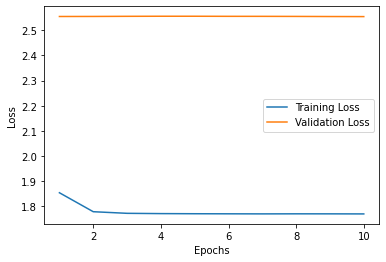

In [58]:
loss_values = model_history.history['loss']
val_loss_values = model_history.history['val_loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.plot(epochs, val_loss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()